Disclaimer: This dataset contains about 10 years of daily weather observations from
numerous Australian weather stations.
Dataset description: RainTomorrow is the target variable to predict. It means - did it rain the next
day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

Task: In this case study, you will build your first Neural Network using PyTorch. You will use it to
predict whether or not is going to rain tomorrow using real weather information.

In [2]:
import numpy as np
import pandas as pd
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
###$

import torch
from torch import nn #neural network
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#$from torchvision import datasets
#$from torchvision.transforms import ToTensor, Lambda, Compose



pd.options.display.max_rows=100
pd.options.display.max_columns=100

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data=pd.read_csv('files/weatherAUS.csv')
df=data.copy()
df.head(60).tail(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
50,2009-01-20,Albury,18.6,39.9,0.0,NaN,NaN,NNW,61.0,SSE,WNW,9.0,20.0,36.0,21.0,1010.1,1004.8,NaN,NaN,26.8,37.7,No,No
51,2009-01-21,Albury,19.3,38.1,0.8,NaN,NaN,NNW,61.0,NE,WSW,15.0,17.0,48.0,17.0,1009.6,1005.9,NaN,NaN,27.3,36.1,No,No
52,2009-01-22,Albury,24.4,34.0,0.6,NaN,NaN,NW,98.0,N,NNW,26.0,48.0,60.0,39.0,1005.3,997.8,4.0,1.0,26.1,33.1,No,Yes
53,2009-01-23,Albury,18.8,35.2,6.4,NaN,NaN,WNW,52.0,S,NW,6.0,28.0,43.0,28.0,1007.9,1003.9,NaN,NaN,22.8,33.0,Yes,No
54,2009-01-24,Albury,20.8,30.6,0.0,NaN,NaN,W,54.0,W,W,30.0,28.0,41.0,21.0,1005.4,1007.6,NaN,NaN,23.3,29.7,No,No
55,2009-01-25,Albury,14.0,34.3,0.0,NaN,NaN,WSW,24.0,ESE,SSE,7.0,13.0,44.0,10.0,1016.5,1014.6,NaN,NaN,21.2,32.1,No,No
56,2009-01-26,Albury,15.7,38.4,0.0,NaN,NaN,S,33.0,SSE,WSW,7.0,7.0,48.0,12.0,1017.7,1014.6,NaN,NaN,23.4,36.5,No,No
57,2009-01-27,Albury,18.5,38.2,0.0,NaN,NaN,NNE,31.0,SE,NNW,9.0,17.0,48.0,25.0,1017.8,1014.1,NaN,NaN,25.8,36.2,No,No
58,2009-01-28,Albury,20.4,40.7,0.0,NaN,NaN,N,37.0,E,NNE,7.0,13.0,45.0,15.0,1014.9,1011.6,NaN,NaN,28.2,39.2,No,No
59,2009-01-29,Albury,21.8,41.5,0.0,NaN,NaN,SW,24.0,ESE,S,6.0,11.0,38.0,13.0,1015.7,1011.8,NaN,NaN,29.0,40.1,No,No


Deep Learningde col sayi artirmaq daha okay netice verir

Nan duzeldende elave col elave edirik ki, 1 ve 0 olaraq nan data duzeldilib ya yox, eynisin outlier ucun de edirik
model ozu qerar versin ne qeder onemli olduquna

In [5]:
df.shape

(145460, 23)

<AxesSubplot:>

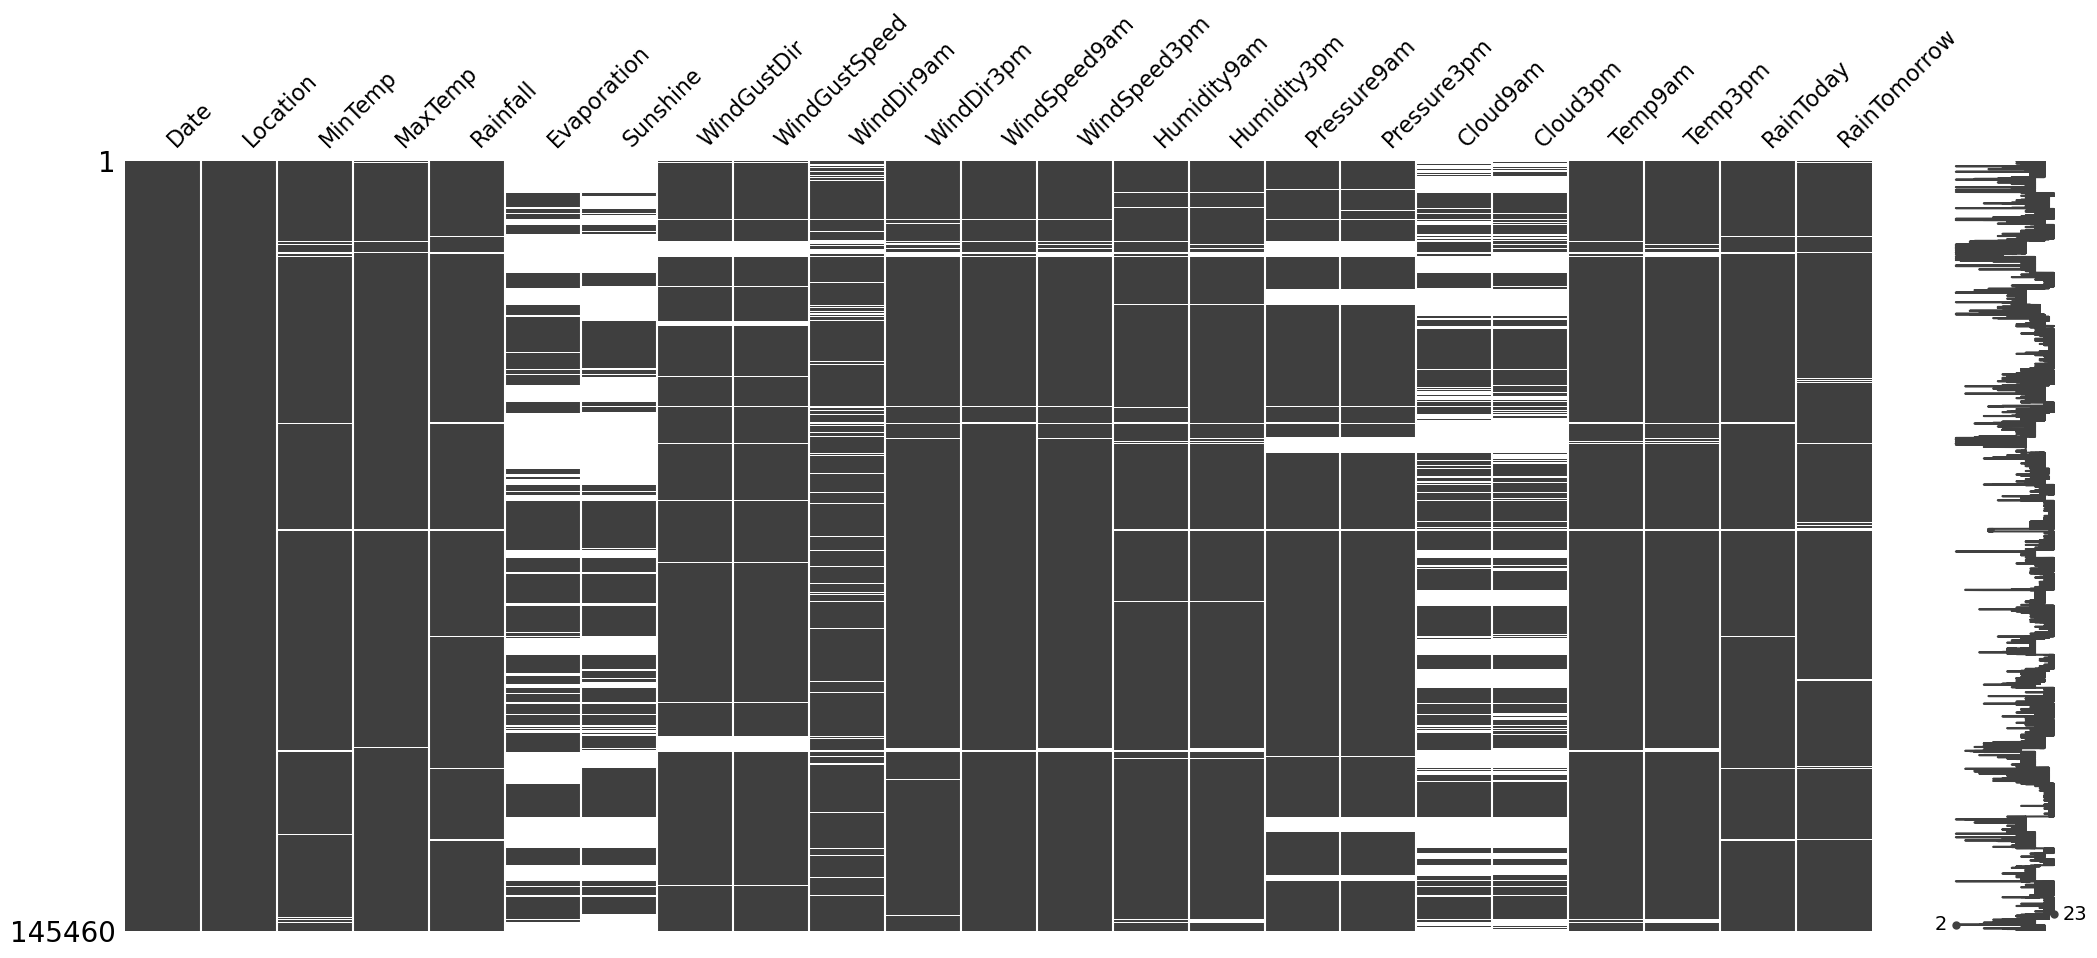

In [6]:
msno.matrix(df)

<AxesSubplot:>

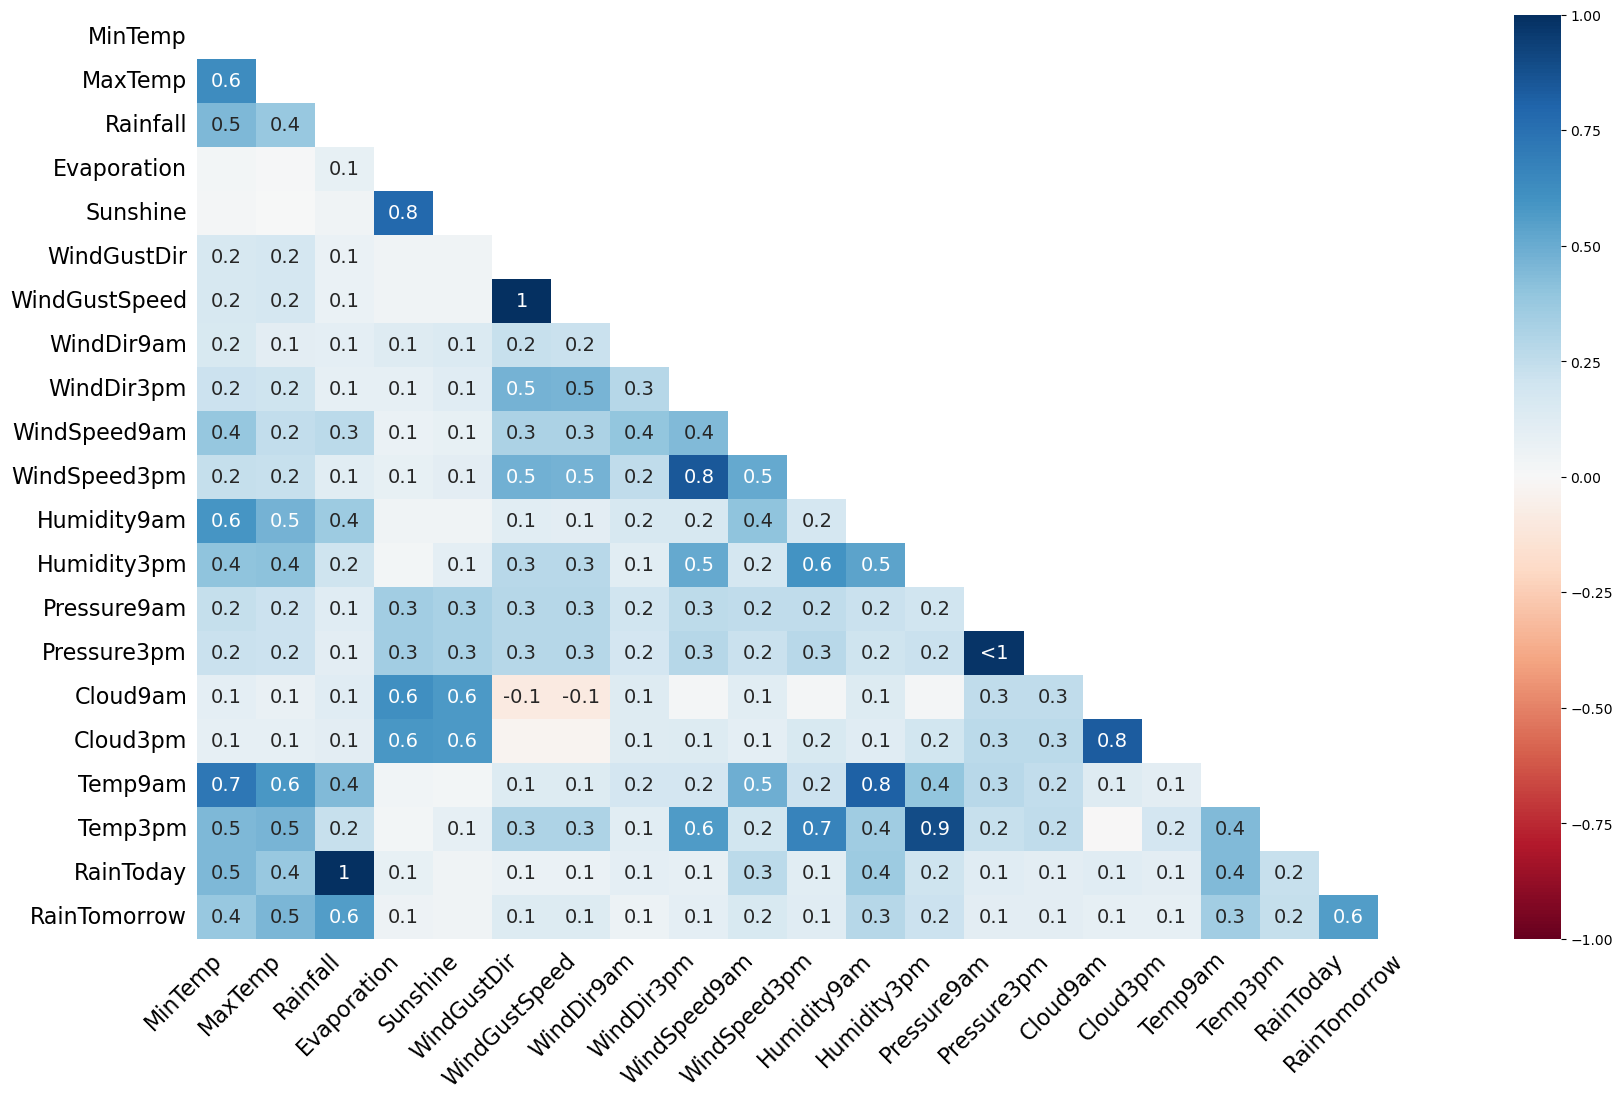

In [7]:
msno.heatmap(df)

<AxesSubplot:>

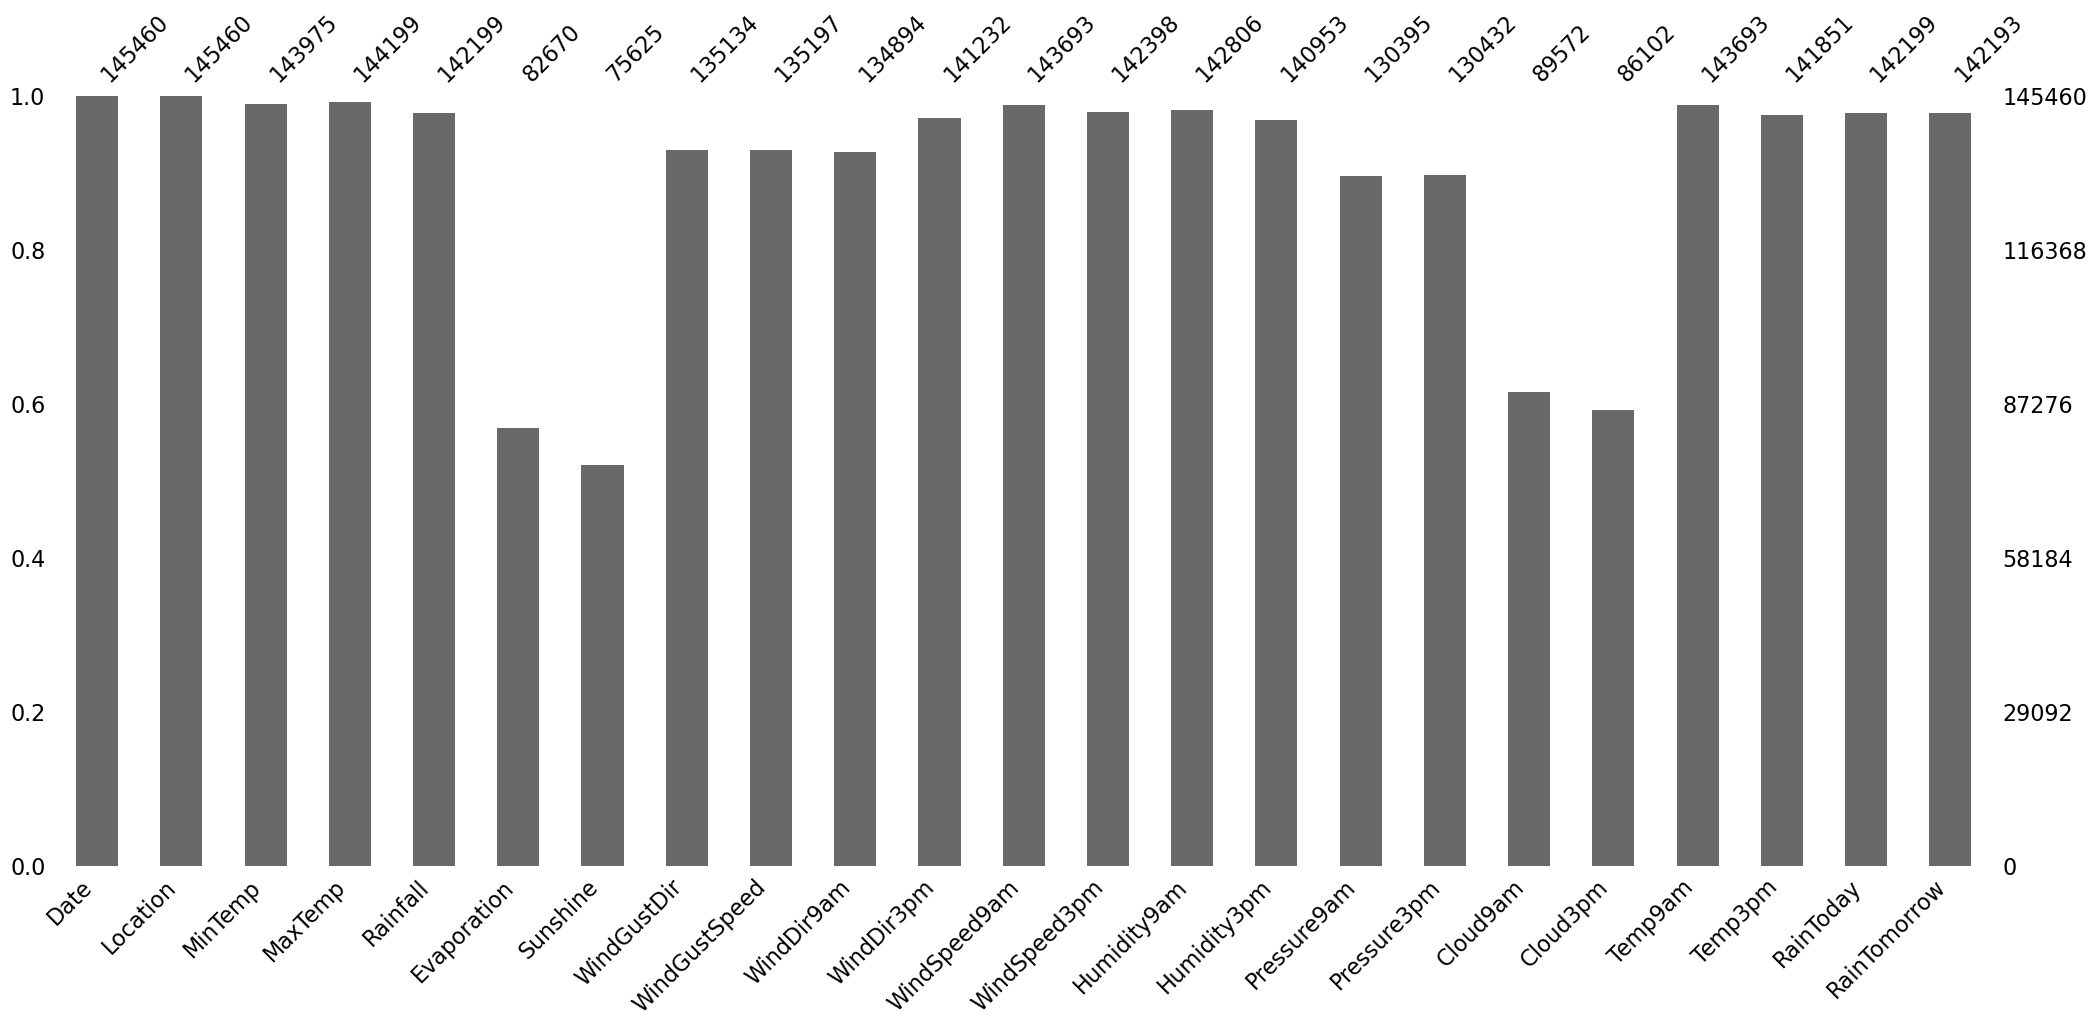

In [8]:
msno.bar(df)

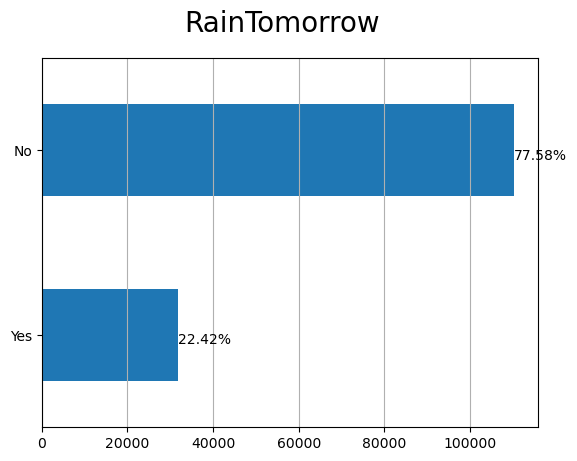

In [9]:
x="RainTomorrow"

ax=df[x].value_counts().sort_values().plot(kind='barh')
totals=[]

for i in ax.patches:
    totals.append(i.get_width())
total=sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.2,
    str(round((i.get_width()/total)*100,2))+'%',
    fontsize=10,color='black' )
    
ax.grid(axis='x')
plt.suptitle(x,fontsize=20)
plt.show()

    

In [10]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [11]:
df.drop(['Evaporation','Sunshine','Cloud9am', 'Cloud3pm'],axis=1,inplace=True)

In [12]:
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [13]:
for i in df.columns:
    if df[i].dtype==object:
        df[i][df[i].isnull()]=df[i].mode()
    else:
        df[i][df[i].isnull()]=df[i].median()

df.dropna(axis=0,inplace=True)        

C:\Users\HP\AppData\Local\Temp\ipykernel_84032\835282327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i].isnull()]=df[i].mode()
C:\Users\HP\AppData\Local\Temp\ipykernel_84032\835282327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i].isnull()]=df[i].mode()
C:\Users\HP\AppData\Local\Temp\ipykernel_84032\835282327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i].isnull()]=df[i].median()
C:\Us

In [14]:
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [15]:
df.shape

(123710, 19)

In [16]:
encoder=LabelEncoder()

for i in df.columns:
    if df[i].dtype==object:
        df[i]=encoder.fit_transform(df[i])

In [17]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,377,1,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,378,1,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,379,1,12.9,25.7,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,380,1,9.2,28.0,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,381,1,17.5,32.3,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


In [18]:
X=df.drop('RainTomorrow',axis=1)
y=df['RainTomorrow'].values.reshape(-1,1)

In [19]:
scaler=RobustScaler()
X=scaler.fit_transform(X)

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4,stratify=y)


### Pytorch Enterence

In [21]:
X_train=torch.from_numpy(X_train).float()
X_test=torch.from_numpy(X_test).float()
y_train=torch.from_numpy(y_train).float()
y_test=torch.from_numpy(y_test).float()

In [22]:
train_dataset=TensorDataset(X_train,y_train)
test_dataset=TensorDataset(X_test,y_test)

In [23]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,shuffle=True)

#### defining architecture

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(18,35)
        self.out = nn.Linear(35,1)

    def forward(self, X):
        X=F.relu(self.fc1(X))
        X=self.out(X)
        return X

In [25]:
model=Model()
model

Model(
  (fc1): Linear(in_features=18, out_features=35, bias=True)
  (out): Linear(in_features=35, out_features=1, bias=True)
)

In [26]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn=nn*s
        pp+=nn
    return pp

In [27]:
get_n_params(model)

701

In [28]:
num_epochs=15
lr_rate=0.05
criterion=nn.BCEWithLogitsLoss()
optimazer=optim.SGD(model.parameters(),lr=lr_rate)

In [29]:
def binary_acc(y_pred,y_test):
    y_pred_tag=torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum=(y_pred_tag==y_test).sum().float()
    acc=correct_results_sum/y_test.shape[0]
    acc=torch.round(acc*100)
    
    return acc
    

#### training model


In [35]:
model.train()

for e in range(1,num_epochs+1):
    epoch_loss=0
    epoch_acc=0
    
    for X_batch, y_batch in train_loader:
        optimazer.zero_grad()
        
        y_pred=model(X_batch)
        
        loss=criterion(y_pred,y_batch)
        acc=binary_acc(y_pred,y_batch)   ##$y_pred.flatten(),y_batch.flatten().float()
        
        loss.backward()
        optimazer.step()
        
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    print(f"Epoch : {e+0:03} :  |Loss: {epoch_loss/len(train_loader):.5f}| Acc: {epoch_acc/len(train_loader):.3f} \n")
        
        

Epoch : 001 :  |Loss: 0.34472| Acc: 85.209 

Epoch : 002 :  |Loss: 0.34447| Acc: 85.256 

Epoch : 003 :  |Loss: 0.34392| Acc: 85.223 

Epoch : 004 :  |Loss: 0.34381| Acc: 85.311 

Epoch : 005 :  |Loss: 0.34350| Acc: 85.261 

Epoch : 006 :  |Loss: 0.34288| Acc: 85.330 

Epoch : 007 :  |Loss: 0.34257| Acc: 85.332 

Epoch : 008 :  |Loss: 0.34255| Acc: 85.319 

Epoch : 009 :  |Loss: 0.34217| Acc: 85.319 

Epoch : 010 :  |Loss: 0.34225| Acc: 85.298 

Epoch : 011 :  |Loss: 0.34230| Acc: 85.283 

Epoch : 012 :  |Loss: 0.34154| Acc: 85.321 

Epoch : 013 :  |Loss: 0.34141| Acc: 85.318 

Epoch : 014 :  |Loss: 0.34148| Acc: 85.345 

Epoch : 015 :  |Loss: 0.34077| Acc: 85.414 



#### testing model

In [38]:
y_train_list=[]
model.eval()

with torch.no_grad():
    for X_batch, y_batch in train_dataset:
        torch.no_grad()
        
        y_train_pred=model(X_batch)
        y_train_pred=torch.sigmoid(y_train_pred) 
        y_pred_tag=torch.round(y_train_pred)
        
        y_train_list.append(y_pred_tag.numpy())
        
        
y_train_list=[a.squeeze().tolist() for a in y_train_list]

In [39]:
len(y_train_list)

98968

In [41]:
print(confusion_matrix(y_train,y_train_list))

[[73029  4025]
 [10324 11590]]


In [ ]:
print(classification_report(y_train,y_train_list))

In [ ]:
y_pred_list=[]
model.eval()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        torch.no_grad()
        
        y_test_pred=model(X_batch)
        y_test_pred=torch.sigmoid(y_test_pred) 
        y_pred_tag=torch.round(y_test_pred)
        
        y_pred_list.append(y_pred_tag.numpy())
        
        
y_pred_list=[a.squeeze().tolist() for a in y_pred_list]

In [ ]:
print(confusion_matrix(y_test,y_pred_list))

In [ ]:
print(classification_report(y_test,y_pred_list))